## import thư viện

In [ ]:
!pip install datasets transformers accelerate

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

In [ ]:
# Kiểm tra GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


## import dataset

In [ ]:
dataset = load_dataset("anti-ai/ViNLI-Zalo-supervised")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/133 [00:00<?, ?B/s]

law_vi.jsonl.gz:   0%|          | 0.00/37.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32980 [00:00<?, ? examples/s]

In [ ]:
print(dataset['train'][0:5])

{'query': ['Tổ sát_hạch cấp giấy_phép lái tàu_hỏa có bao_nhiêu thành_viên ?', 'Văn_bản điều_chỉnh hoạt_động tổ_chức đào_tạo nghề cho lao_động trong doanh_nghiệp nhỏ và vừa được quy_định như thế_nào ?', 'Phó chỉ_huy_trưởng Ban chỉ_huy quân_sự xã được hưởng chế_độ phụ_cấp đặc_thù như thế_nào ?', 'Thực_hiện dân_chủ trong cơ_sở giáo_dục công_lập thì người đứng đầu đoàn_thể có những trách_nhiệm nào ?', 'Mức phạt nếu điều_khiển xe ô_tô lắp thêm đèn'], 'positive': ['Điều 30 . Tổ sát_hạch 1 . Tổ sát_hạch do Cục_trưởng Cục Đường_sắt Việt_Nam thành_lập , chịu sự chỉ_đạo trực_tiếp của Hội_đồng sát_hạch . \n 2 . Tổ sát_hạch có ít_nhất 05 thành_viên , bao_gồm tổ_trưởng , các sát_hạch viên lý_thuyết và sát_hạch viên thực_hành . Tổ_trưởng Tổ sát_hạch là công_chức Cục Đường_sắt Việt_Nam hoặc lãnh_đạo doanh_nghiệp có thí_sinh dự kỳ sát_hạch , các sát_hạch viên là người đang công_tác tại doanh_nghiệp có thí_sinh tham_dự kỳ sát_hạch và người đang công_tác tại các cơ_sở đào_tạo liên_quan đến lái tàu . \n 

## cấu trúc lại dataset

In [ ]:
def restructure_data(split):
    query_list = dataset[split]["query"]
    positives = dataset[split]["positive"]
    negatives = dataset[split]["hard_neg"]

    samples = []
    for q, pos, neg in zip(query_list, positives, negatives):
        samples.append({"query": q, "document": pos, "label": 1})
        samples.append({"query": q, "document": neg, "label": 0})
    random.shuffle(samples)
    return Dataset.from_list(samples)

In [ ]:
train_full = restructure_data("train")

## chia train/dev/test

In [ ]:
split = train_full.train_test_split(test_size=0.1, seed=42)
temp_train = split["train"]
test_dataset = split["test"]

train_valid = temp_train.train_test_split(test_size=0.1, seed=42)
train_dataset = train_valid["train"]
valid_dataset = train_valid["test"]

In [ ]:
print("Train:", len(train_dataset))
print("Valid:", len(valid_dataset))
print("Test:", len(test_dataset))

Train: 53427
Valid: 5937
Test: 6596


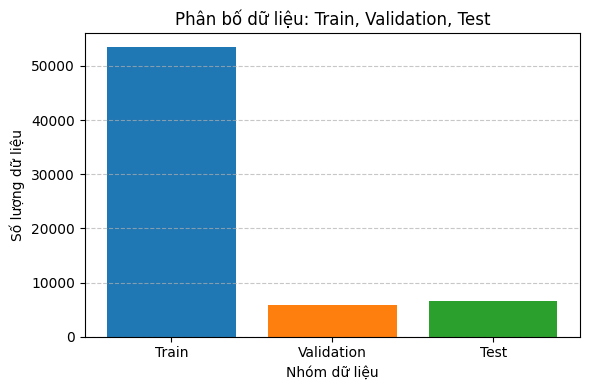

In [ ]:
data_counts = {
    'Train': len(train_dataset),
    'Validation': len(valid_dataset),
    'Test': len(test_dataset)
}

keys = list(data_counts.keys())
values = list(data_counts.values())

# Lấy màu từ colormap mặc định 'tab10'
cmap = plt.get_cmap('tab10')
colors = cmap(np.arange(len(values)))

plt.figure(figsize=(6, 4))
plt.bar(keys, values, color=colors)
plt.title('Phân bố dữ liệu: Train, Validation, Test')
plt.ylabel('Số lượng dữ liệu')
plt.xlabel('Nhóm dữ liệu')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## tokenizer load

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "Alibaba-NLP/gte-multilingual-reranker-base",
    trust_remote_code=True
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(examples):
    res = tokenizer(
        examples["query"],
        examples["document"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    res["labels"] = [float(x) for x in examples["label"]]
    return res

In [ ]:
tokenized_train = train_dataset.map(tokenize_fn, batched=True, remove_columns=train_dataset.column_names)
tokenized_valid = valid_dataset.map(tokenize_fn, batched=True, remove_columns=valid_dataset.column_names)
tokenized_test  = test_dataset.map(tokenize_fn, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/53427 [00:00<?, ? examples/s]

Map:   0%|          | 0/5937 [00:00<?, ? examples/s]

Map:   0%|          | 0/6596 [00:00<?, ? examples/s]

## model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "Alibaba-NLP/gte-multilingual-reranker-base",
    trust_remote_code=True
)

config.json: 0.00B [00:00, ?B/s]

configuration.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/612M [00:00<?, ?B/s]

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    scores = pred.predictions.squeeze()
    preds = (scores > 0).astype(int)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./reranker_ckpt",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=10,
    weight_decay=0.25,
    fp16=True,
    warmup_ratio=0.1,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="none",
    label_names=["labels"],
    remove_unused_columns=False
)

### train

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/tmp/ipython-input-2669883495.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.053600,0.003204,0.896918,0.826383,1.000000,0.904939
2,0.002700,0.001700,0.978272,0.957594,1.000000,0.978338
3,0.001000,0.001172,0.998653,0.997261,1.000000,0.998629
4,0.000900,0.001754,0.995789,0.991491,1.000000,0.995727
5,0.000500,0.002008,0.997473,0.994877,1.000000,0.997432
6,0.000300,0.002110,0.997473,0.994877,1.000000,0.997432


TrainOutput(global_step=5010, training_loss=0.009843358355843854, metrics={'train_runtime': 11852.9005, 'train_samples_per_second': 45.075, 'train_steps_per_second': 0.704, 'total_flos': 1.1218661336536474e+17, 'train_loss': 0.009843358355843854, 'epoch': 6.0})

### lưu

In [ ]:
model.save_pretrained("/content/drive/MyDrive/DS310/rerank_model")
tokenizer.save_pretrained("/content/drive/MyDrive/DS310/rerank_model")
print("Model saved!")

Model saved!
